# Distributed Differentially Private Maximum Likelihood Estimation and Online Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from lifelines import KaplanMeierFitter, ExponentialFitter, CoxPHFitter
import time
import scipy.stats
import netgraph
from scipy.special import expit, softmax, logit

palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

sns.set_palette(palette)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


The following code constructs the communication network $A$ based on the Metropolis-Hastings weights

In [3]:
def build_network(G):
    A = nx.to_numpy_array(G).astype(np.float64)
    n = A.shape[0]

    d = A.sum(0)

    for i in range(n):
        A[i, i] = 0
        for j in range(i):
            if A[i, j] != 0:
                A[i, j] = 1.0 / max(d[i], d[j])
                A[j, i] = A[i, j]
    
    for i in range(n):
        A[i, i] = 1 - A[i, :].sum()

    return A, n

## Distributed Survival Analysis

We use the following two datasets: 

* ACTGS 175: [Kaggle Link](https://www.kaggle.com/code/gauravduttakiit/dataset-aids-clinical-trials-group-study-175)
* Cancer Study Data: [Samstein et al. (2019)](https://www.nature.com/articles/s41588-018-0312-8). 

A copy of the data is located in the `datasets/` directory.

* For the ACTGS We plot the Kaplan-Meier survival curves for ZDV (control) and ddI (treatment), as well as the log hazard ratios by fitting a proportional hazard model using the treatment variable as a regression covariate.
* For the cancer study we plot the Kaplan-Meier survival curve for three quantiles with respect to the TMB (high TMB, medimum TMB, low TMB), we plot the log hazard ratios by fitting a proportional hazard model using the treatment variables.

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/1928525465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df['trt'] == val
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/1928525465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df['trt'] == val
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/1928525465.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

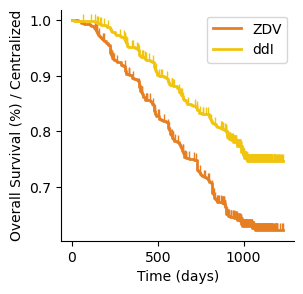

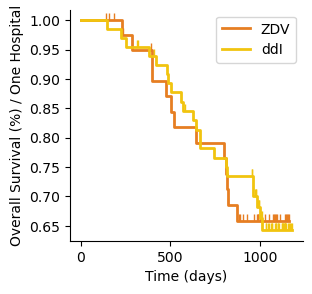

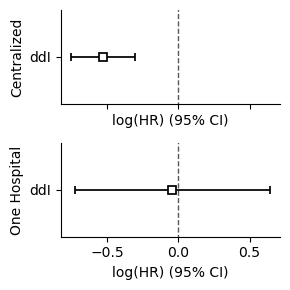

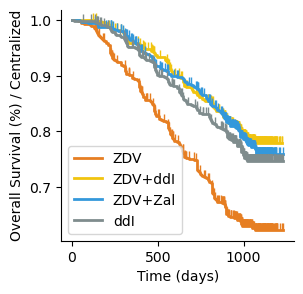

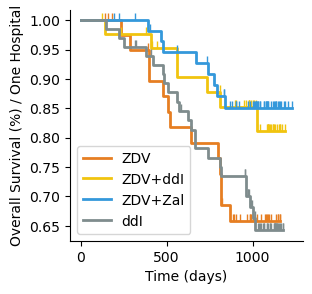

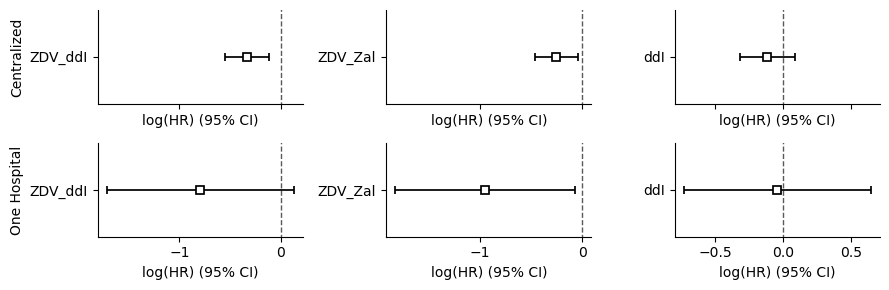

In [4]:
def load_hiv_data(control=('ZDV', 0), treatments=[('ddI', 3)]):
    df = pd.read_csv('datasets/atcg_study175/AIDS_ClinicalTrial_GroupStudy175.csv')

    all_treatments = dict([control] + treatments) 

    df = df.query(' | '.join([f'trt == {val}' for val in all_treatments.values()]))

    for key, val in all_treatments.items():
        df[key] = df['trt'] == val

    return df

def plot_hiv_data(df, num_hospitals=10, control=('ZDV', 0), treatments=[('ddI', 3)], suffix=''):

    all_treatments = dict([control] + treatments)

    df['Hospital'] = df.index % num_hospitals

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name, val in all_treatments.items():
        kmf = KaplanMeierFitter()
        df_trt = df.query(f'trt == {val}')
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=name.replace('_', '+'))
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / Centralized')
    ax.set_xlabel('Time (days)')

    fig.savefig(f'figures/survival_curves_hiv{suffix}.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    df_one_hospital = df.query('Hospital == 1')

    for name, val in all_treatments.items():
        kmf = KaplanMeierFitter()
        df_trt = df_one_hospital.query(f'trt == {val}')
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=f"{name.replace('_', '+')}")
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / One Hospital')
    ax.set_xlabel('Time (days)')

    fig.savefig(f'figures/survival_curves_hiv_one_hospital{suffix}.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(2, len(treatments), figsize=(3 * len(treatments), 3), sharex='col', squeeze=False)

    for i, (name, val) in enumerate(treatments):
        df_trt = df.query(f'trt == {val} | trt == {control[1]}')
        df_trt[val] = df_trt['trt'] == val

        cph = CoxPHFitter()

        cph.fit(df[['time', 'label', name]], duration_col='time', event_col='label', formula=name)

        cph.plot(ax=ax[0, i])

        sns.despine()

        cph_hospital = CoxPHFitter()

        df_one_hospital = df_trt.query('Hospital == 1')

        cph_hospital.fit(df_one_hospital[['time', 'label', name]], duration_col='time', event_col='label', formula=name)

        cph_hospital.plot(ax=ax[1, i])

        # ax[0].set_yticklabels(['Treatment'])
        # ax[1].set_yticklabels(['Treatment'])

    ax[0, 0].set_ylabel('Centralized')
    ax[1, 0].set_ylabel('One Hospital')

    fig.tight_layout()

    fig.savefig(f'figures/cox_proportional_hazard_model_hiv{suffix}.pdf', bbox_inches='tight')

df_atsg = load_hiv_data(control=('ZDV', 0), treatments=[('ddI', 3)])
plot_hiv_data(df_atsg, treatments=[('ddI', 3)])

# Treatment IDs: (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)

df_atsg_multi = load_hiv_data(control=('ZDV', 0), treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)])
plot_hiv_data(df_atsg_multi, treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)], suffix='_multi')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/2855007620.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

125        Top 10%
269        Top 10%
721        Top 10%
230        Top 10%
1370       Top 10%
           ...    
101     Bottom 80%
504     Bottom 80%
1559    Bottom 80%
794     Bottom 80%
1584    Bottom 80%
Name: Group, Length: 1662, dtype: object


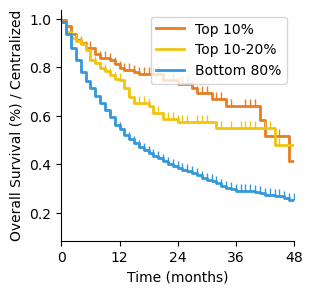

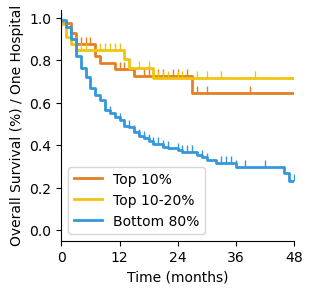

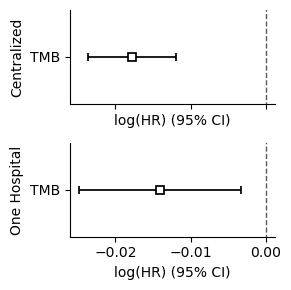

In [5]:
def load_tmb_data():
    df = pd.read_excel('datasets/41588_2018_312_MOESM3_ESM.xlsx', header=1)
    df = df.sort_values(by='TMB', ascending=False)

    indices = {
        'Top 10%' : (0, int(0.1 * len(df))),
        'Top 10-20%' : (int(0.1 * len(df)), int(0.2 * len(df))),
        'Bottom 80%' : (int(0.2 * len(df)), len(df))
    }

    # Create groups based on the above indices where the indices are (start, end) pairs based on TMB values
    df['Group'] = ''

    for name, (start, end) in indices.items():
        df['Group'].iloc[start:end] = name

    print(df['Group'])


    return df

def plot_tmb_data(df, num_hospitals=5):

    df['Hospital'] = df.index % num_hospitals

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name in df['Group'].unique():
        df_group = df.query(f'Group == "{name}"')
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_group['SURVIVAL_MONTHS'], event_observed=df_group['SURVIVAL_EVENT'], label=name)
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)
    ax.set_xlim(0, 48)

    ax.set_ylabel('Overall Survival (%) / Centralized')
    ax.set_xlabel('Time (months)')

    ax.set_xticks([0, 12, 24, 36, 48])
   
    fig.savefig('figures/survival_curves_tmb.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    df_one_hospital = df.query('Hospital == 1')

    for name in df['Group'].unique():
        df_group = df_one_hospital.query(f'Group == "{name}" and Hospital == 1')
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_group['SURVIVAL_MONTHS'], event_observed=df_group['SURVIVAL_EVENT'], label=name)
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)
    
    sns.despine()
    ax.grid(False)
    ax.set_xlim(0, 48)

    ax.set_ylabel('Overall Survival (%) / One Hospital')
    ax.set_xlabel('Time (months)')

    fig.savefig('figures/survival_curves_tmb_one_hospital.pdf', bbox_inches='tight')

    ax.set_xticks([0, 12, 24, 36, 48])

    cph = CoxPHFitter()

    fig, ax = plt.subplots(2, 1, figsize=(3, 3), sharex=True)

    cph.fit(df[['SURVIVAL_EVENT', 'SURVIVAL_MONTHS', 'TMB']], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')
    
    cph.plot(ax=ax[0])

    cph.fit(df_one_hospital[['SURVIVAL_EVENT', 'SURVIVAL_MONTHS', 'TMB']], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')

    cph.plot(ax=ax[1])

    sns.despine()

    ax[0].set_ylabel('Centralized')
    ax[1].set_ylabel('One Hospital')

    fig.tight_layout()

    fig.savefig('figures/cox_ph_tmb.pdf', bbox_inches='tight')
    
df_tmb = load_tmb_data()
plot_tmb_data(df_tmb)


## Distributed Proportional Hazards Model

### Model Description

We assume the proportional hazards model where each hospital $i$ has partial likelihood $$ \log \ell_i (\bm S_i | \theta) = \sum_{j: \bm s_{ij} = 1} \left (\bm x_{ij} \theta - \log \sum_{j' : \bm t_{ij'} \ge \bm t_{ij}} e^{\bm x_{ij'}\theta } \right ),$$

where

* $\bm s_{ij}$ is the signal (whether the patient survived or not)
* $\bm t_{ij}$ is the time the event $\bm s_{ij}$ happened
* $\bm x_{ij}$ is the covariate

In [6]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def plot_beliefs_graph(G, A, beliefs, log_belief_ratios, titles, suptitle='', outfile=None, node_layout='circular', t=-1):
        
    fig, ax = plt.subplots(1, len(beliefs), figsize=(3 * len(beliefs), 3))

    cmap = plt.cm.get_cmap('Reds')

    n = len(G)

    for i, belief in enumerate(beliefs):

        node_color = {i: 'white' for i in range(n)}
        edge_color = {(i, j): cmap(A[i, j]) for i, j in G.edges()}

        node_labels = {i: f'{i + 1}\n({belief[i, t]:.2f})' for i in range(n)}
        node_label_fontdict=dict(color='black', weight='bold')

        netgraph.Graph(G, ax=ax[i], node_size=10, edge_width=1.5, node_labels=node_labels, node_label_fontdict=node_label_fontdict, node_color=node_color, edge_color=edge_color, node_layout=node_layout)

        plt.Normalize(vmin=0, vmax=1)

        ax[i].set_title(titles[i])


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    fig.suptitle(suptitle)

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

def plot_beliefs_barplot(beliefs, labels, threshold, suptitle='', outfile=None, t=-1):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    records = []

    for i, (belief, label) in enumerate(zip(beliefs, labels)):
        for j in range(belief.shape[0]):
            record = {
                'Hospital' : j + 1,
                'Belief' : belief[j, t],
                'Hypothesis' : label
            }

            records.append(record)

    records = pd.DataFrame(records)

    if threshold:
        ax.axhline(threshold, color='black', linestyle='--', label='Threshold')

    sns.barplot(x='Hospital', y='Belief', hue='Hypothesis', data=records, ax=ax)

    ax.set_title(suptitle)


    ax.set_ylim([0, 1])

    sns.despine()

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

# get the score function for the cox proportional hazard model
def get_score_function_cox(X, T, D, beta):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    score = np.zeros_like(beta)

    den_sum = np.cumsum(theta[::-1])[::-1]
    num_sum = np.cumsum((X[:, 0]*theta)[::-1])[::-1]

    score = np.sum(D * (X[:, 0] - num_sum / den_sum))

    return score

def get_sensitivity_cox(X, T, D, beta):
    score = get_score_function_cox(X, T, D, beta)
    return np.max(np.abs(score))

def get_log_likelihood_cox(X, T, D, beta):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    log_likelihood = 0

    temp_sum = np.cumsum(theta[::-1])[::-1] + 1e-10

        
    log_likelihood = np.sum(D * (X @ beta) - np.log(temp_sum))

    return log_likelihood


def distributed_survival_analysis(df, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=0.01, plot=True, node_layout='spring', suffix='', network_protection=False, intermittent=False, **kwargs):
    eta = max(alpha, 1 - beta)
    
    threshold = 1 / (1 + np.exp(rho))

    start_time = time.time()
    
    np.random.seed(0)

    df['Hospital'] = df.index % num_hospitals

    # Create a network of hospitals
    if not G:
        G = nx.complete_graph(num_hospitals)

    # Get communication matrix
    A, _ = build_network(G)
    I = np.eye(num_hospitals)

    if intermittent:
        intermittent_period = kwargs.get('intermittent_period', 10)
        df['Period'] = df[time_col] // intermittent_period + 1
        num_iterations = df['Period'].max()

        log_likelihood_null_hospitals = np.zeros(shape=(num_hospitals, num_iterations))
        log_likelihood_alternative_hospitals = np.zeros(shape=(num_hospitals, num_iterations))

    else:
        log_likelihood_null_hospitals = np.zeros(num_hospitals)
        log_likelihood_alternative_hospitals = np.zeros(num_hospitals)

    Gamma_global = -np.inf
    l_global = 0
    num_hypotheses = kwargs.get('num_hypotheses', 2)
    
    # get sorted eigenvalues of A + I
    eigenvalues = np.sort(np.linalg.eigvals(A + I))[::-1]
    slem = np.max(np.abs(eigenvalues[1:]))
    alpha = 1/2 * slem


    if network_protection:
        Delta_global = np.max(A * (1 - np.eye(num_hospitals)))
    else:
        Delta_global = -np.inf

    start_time = time.time()

    for i in range(num_hospitals):
        if intermittent:
            for t in range(1, 1 + num_iterations):
                df_period = df[df['Period'] == t]
                log_likelihood_null_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, np.zeros_like(alternative))
                log_likelihood_alternative_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, alternative)

                Delta_alternative = get_sensitivity_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, alternative)
                Delta_null = get_sensitivity_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, np.zeros_like(alternative))

                Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i, t-1]), np.abs(log_likelihood_null_hospitals[i, t-1])])
                l_global += log_likelihood_alternative_hospitals[i, t-1] - log_likelihood_null_hospitals[i, t-1]
                Delta_global = max([Delta_global, Delta_null, Delta_alternative])

        else:
            log_likelihood_null_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, np.zeros_like(alternative))
            log_likelihood_alternative_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, alternative)

            Delta_alternative = get_sensitivity_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, alternative)
            Delta_null = get_sensitivity_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, np.zeros_like(alternative))

            Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i]), np.abs(log_likelihood_null_hospitals[i])])
            l_global += log_likelihood_alternative_hospitals[i] - log_likelihood_null_hospitals[i] 

            Delta_global = max([Delta_global, Delta_null, Delta_alternative])

    l_global = np.abs(l_global)
    
    if intermittent:
        num_runs = 1
        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))
    
    else:
        if 'num_runs' in kwargs:
            num_runs = kwargs['num_runs']
        else:
            num_runs = int(np.ceil(num_hypotheses * np.log(num_hypotheses / eta)))

        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))

    for i in range(num_hospitals):
        if intermittent:
            for t in range(1, 1 + num_iterations):
                noise_alternative = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                noise_null = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                log_likelihood_alternative_hospitals_private[i, t-1] = log_likelihood_alternative_hospitals[i, t-1] + noise_alternative
                log_likelihood_null_hospitals_private[i, t-1] = log_likelihood_null_hospitals[i, t-1] + noise_null
        else:
            for j in range(num_runs):  
                noise_alternative = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                noise_null = np.random.laplace(0, 2 * num_runs * Delta_global / epsilon)
                
                log_likelihood_alternative_hospitals_private[i, j] = log_likelihood_alternative_hospitals[i] + noise_alternative
                log_likelihood_null_hospitals_private[i, j] = log_likelihood_null_hospitals[i] + noise_null

    runtime_likelihoods = time.time() - start_time

    start_time = time.time()

    if intermittent:
        log_belief_ratio_distributed = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals
        log_belief_ratio_private_distributed = log_likelihood_alternative_hospitals_private - log_likelihood_null_hospitals_private


    else:
        if 'num_iterations' in kwargs:
            num_iterations = kwargs['num_iterations']
        else:
            num_iterations = int(np.ceil(num_hypotheses * max(np.log(num_hospitals / l_global), np.log((num_hypotheses * (Gamma_global + Delta_global / epsilon))/ (rho * eta)) / np.log(1 / alpha))))

        log_belief_ratio_distributed = np.zeros(shape=(num_hospitals, num_iterations))
        log_belief_ratio_private_distributed = np.zeros(shape=(num_hospitals, num_runs, num_iterations))

        log_belief_ratio_distributed[:, 0] = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals

        for j in range(num_runs):
            log_belief_ratio_private_distributed[:, j, 0] = log_likelihood_alternative_hospitals_private[:, j] - log_likelihood_null_hospitals_private[:, j]

    for i in range(1, num_iterations):
        if intermittent:
            log_belief_ratio_distributed[:, i] += A @ log_belief_ratio_distributed[:, i-1]
            log_belief_ratio_private_distributed[:,  i] += A @ log_belief_ratio_private_distributed[:, i-1]
        else:
            log_belief_ratio_distributed[:, i] = (A + I) @ log_belief_ratio_distributed[:, i-1]
        
            for j in range(num_runs):
                log_belief_ratio_private_distributed[:, j, i] = (A + I) @ log_belief_ratio_private_distributed[:, j, i-1]

    runtime_communication = time.time() - start_time

    T_range = np.arange(1, num_iterations + 1)

    if intermittent:
        belief_null = expit(log_belief_ratio_distributed)
        belief_null_private = expit(log_belief_ratio_private_distributed)

        belief_alternative = 1 - belief_null
        belief_alternative_private = 1 - belief_null_private

        if plot:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio / $t$')

            avg_log_belief_ratio_no_dp = (log_belief_ratio_distributed[:, -1] / T_range[-1]).mean()

            for i in range(num_hospitals):
                ax.plot(T_range, log_belief_ratio_private_distributed[i, :] / T_range)

            ax.axhline(avg_log_belief_ratio_no_dp, color='black', linestyle='--', label=f'No DP (Value = {avg_log_belief_ratio_no_dp:.2f})', linewidth=2)

            ax.legend()

            ax.set_xlim(1, num_iterations)

            ax.grid(False)
            
            ax.set_xscale('log')
            
            sns.despine()

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_ol_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            # fig, ax = plt.subplots(1, 1, figsize=(3, 3))

            # fig.supxlabel('Iteration (t)')
            # fig.supylabel('Total Variation Distance')

            # tvd_ol_no_dp =  np.abs(belief_alternative[i, :] - 1).mean()

            # for i in range(num_hospitals):
            #     ax.plot(T_range, np.abs(belief_alternative_private[i, :] - 1))

            # ax.set_xlim(1, num_iterations)

            # ax.axhline(tvd_ol_no_dp, color='black', linestyle='--', label='No DP', linewidth=2)
            # ax.grid(False)

            # ax.legend()

            # ax.set_xscale('log')

            # sns.despine()

            # fig.tight_layout()

            # fig.savefig(f'figures/distributed_cox_regression_tvd_ol_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            plot_beliefs_barplot([belief_null, belief_alternative], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle=f'Without DP', outfile=f'figures/no_dp_ol{suffix}.pdf')

            plot_beliefs_barplot([belief_null_private, belief_alternative_private], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle='With DP', outfile=f'figures/dp_ol{suffix}.pdf')

        tvd_ol = np.abs(belief_alternative_private[:, -1] - 1).mean()

        return log_belief_ratio_private_distributed, log_belief_ratio_distributed, runtime_likelihoods, runtime_communication, tvd_ol
            
    else:
        log_belief_ratio_private_distributed_geometric_mean = log_belief_ratio_private_distributed.mean(1)

        belief_null = expit(log_belief_ratio_distributed)
        belief_null_private = expit(log_belief_ratio_private_distributed)

        belief_null_private_geometric_mean = expit(log_belief_ratio_private_distributed_geometric_mean)
        belief_null_private_arithmetric_mean = belief_null_private.mean(1)

        belief_alternative = 1 - belief_null
        belief_alternative_private_geometric_mean = 1 - belief_null_private_geometric_mean
        belief_alternative_private_arihtmetic_mean = 1 - belief_null_private_arithmetric_mean
        belief_alternative_private = 1 - belief_null_private

        log_belief_ratio_private_distributed_arithmetic_mean = np.log(belief_null_private_arithmetric_mean / belief_alternative_private_arihtmetic_mean)

        belief_null_private_count = (belief_null_private > 0).mean(1)
        belief_alternative_private_count = (belief_alternative_private > 0).mean(1)

        log_belief_ratio_private_distributed_count = np.log(belief_null_private_count / belief_alternative_private_count)
        
        # recovery of sets 

        theta_gm_alternative = belief_alternative_private_geometric_mean[:, -1] > threshold
        theta_gm_null = belief_null_private_geometric_mean[:, -1] > threshold

        theta_am_alternative = belief_alternative_private_arihtmetic_mean[:, -1] > threshold
        theta_am_null = belief_null_private_arithmetric_mean[:, -1] > threshold

        # GM should recover a subset of {1}: {} -> 1, {1} -> 1, {0} -> 0, {1, 0} -> 0
        type_1_gm = 1 - ((theta_gm_alternative & ~theta_gm_null) | (~theta_gm_alternative & ~theta_gm_null)).mean()

        # AM should always recover a superset of {1} : {} -> 0, {1} -> 1, {0} -> 0, {1, 0} -> 1
        type_2_am = 1 - ((theta_am_alternative & ~theta_am_null) | (theta_am_alternative & theta_am_null)).mean()

        tvd_gm = np.abs(belief_alternative_private_geometric_mean[:, -1] - 1).mean()
        tvd_am = np.abs(belief_alternative_private_arihtmetic_mean[:, -1] - 1).mean()
        tvd_count = np.abs(belief_alternative_private_count - 1).mean()

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)

            # fig.suptitle(f'$\epsilon={epsilon}, n = {num_hospitals}, T = {num_iterations}, K = {num_runs}$')

            ax[0, 0].set_title(f'GM Estimator')
            
            ax[0, 1].set_title(f'AM Estimator')
            
            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio')

            log_belief_ratio_no_dp = -2 * log_belief_ratio_distributed[:, -1].mean()
        
            for i in range(num_hospitals):
                ax[0, 0].plot(T_range, -2 * log_belief_ratio_private_distributed_geometric_mean[i, :] * (1 + np.random.uniform()))
                ax[0, 1].plot(T_range, -2 * log_belief_ratio_private_distributed_arithmetic_mean[i, :] * (1 + np.random.uniform()))

            # ax[0, 0].axhline(log_belief_ratio_no_dp, color='black', linestyle='--', label='No DP', linewidth=2)
            # ax[0, 1].axhline(log_belief_ratio_no_dp, color='black', linestyle='--', label='No DP', linewidth=2)

            ax[0, 0].set_xlim(1, num_iterations)
            ax[0, 1].set_xlim(1, num_iterations)
            

            ax[0, 0].grid(False)
            sns.despine()
            ax[0, 1].grid(False)
            sns.despine()
            
            ax[0, 0].set_xscale('log')
            ax[0, 1].set_xscale('log')
            
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)

            ax[0, 0].set_title(f'GM Estimator')
            ax[0, 1].set_title(f'AM Estimator')
            
            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            tvd_no_dp = np.abs(belief_alternative[:, -1] - 1).mean()
        
            for i in range(num_hospitals):
                ax[0, 0].plot(T_range, np.abs(belief_alternative_private_geometric_mean[i, :] - 1))
                ax[0, 1].plot(T_range, np.abs(belief_alternative_private_arihtmetic_mean[i, :] - 1))

            ax[0, 0].set_xlim(1, num_iterations)
            ax[0, 1].set_xlim(1, num_iterations)

            ax[0, 0].axhline(tvd_no_dp, color='black', linestyle='--', label=f'No DP (Value = {tvd_no_dp:.2f})', linewidth=2)
            ax[0, 1].axhline(tvd_no_dp, color='black', linestyle='--', label=f'No DP (Value = {tvd_no_dp:.2f})', linewidth=2)

            ax[0, 1].legend()

            ax[0, 0].grid(False)
            sns.despine()
            ax[0, 1].grid(False)
            sns.despine()
            
            ax[0, 0].set_xscale('log')
            ax[0, 1].set_xscale('log')

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 1, figsize=(3, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio')

            for i in range(num_hospitals):
                ax.plot(T_range, -2 * log_belief_ratio_private_distributed_count[i, :] * (1 + np.random.uniform()))

            ax.set_xlim(1, num_iterations)
            ax.grid(False)
            sns.despine()

            ax.set_xscale('log')
        
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_count_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 1, figsize=(3, 3))


            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            for i in range(num_hospitals):
                ax.plot(T_range, np.abs(belief_alternative_private_count[i, :] - 1))

            ax.set_xlim(1, num_iterations)
            ax.grid(False)
            sns.despine()

            ax.set_xscale('log')
        
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_count_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')


            # plot_beliefs_graph(G, A, [belief_alternative, belief_alternative_private[:, 0, :]], [log_belief_ratio_distributed, log_belief_ratio_private_distributed[:, 0, :]], ['No DP', '$\\varepsilon$-DP Noising'], suptitle=f'Initial Signals ($T = {num_iterations}, \\varepsilon = {epsilon}$)', outfile=f'figures/mle{suffix}.pdf', node_layout=node_layout)
            # plot_beliefs_graph(G, A, [belief_alternative_private_geometric_mean, belief_alternative_private_arihtmetic_mean], [log_belief_ratio_private_distributed_geometric_mean, log_belief_ratio_private_distributed_arithmetic_mean], ['Geometric Mean', 'Arithmetic Mean'], suptitle=f'Aggregate MLE (Star Graph, $T = {num_iterations}, K = {num_runs}, \\eta = {eta}, \\varepsilon = {epsilon}$)', outfile=f'figures/aggregate_mle{suffix}.pdf', node_layout=node_layout)

            plot_beliefs_barplot([belief_null_private_geometric_mean, belief_alternative_private_geometric_mean], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle=f'Geometric Mean', outfile=f'figures/geometric_mean{suffix}.pdf')
            plot_beliefs_barplot([belief_null_private_arithmetric_mean, belief_alternative_private_arihtmetic_mean], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle=f'Arithmetic Mean', outfile=f'figures/arithmetic_mean{suffix}.pdf')

            plot_beliefs_barplot([belief_null, belief_alternative], ['$\\theta = 0$', '$\\theta = 1$'], None, suptitle=f'No DP', outfile=f'figures/no_dp{suffix}.pdf')

            plot_beliefs_barplot([belief_null_private_count, belief_alternative_private_count], ['$\\theta = 0$', '$\\theta = 1$'], threshold, suptitle='', outfile=f'figures/count{suffix}.pdf')

        return log_belief_ratio_private_distributed, log_belief_ratio_distributed, runtime_likelihoods, runtime_communication, tvd_gm, tvd_am, tvd_count, type_1_gm, type_2_am

def distributed_survival_analysis_pvalue(num_bootstrap, batch_size, df, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=0.01):

    statistics = []

    for i in range(num_bootstrap):
        df_bootstrap = df.sample(n=batch_size, replace=True)

        log_belief_ratio_private_distributed, _, _, _, _, _, _, _, = distributed_survival_analysis(df_bootstrap, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=rho, plot=False)

        statistics.append(log_belief_ratio_private_distributed[:, :, -1])

    statistics = np.array(statistics)

    thresholds = np.zeros(num_hospitals)

    for i in range(num_hospitals):
        thresholds[i] = np.percentile(statistics[:, i, :], 100 * (1 - alpha))

    p_values = np.zeros(num_hospitals)

    for i in range(num_hospitals):
        p_values[i] = (statistics[:, i, :] > thresholds[i]).mean()

    return p_values

### Beliefs plot

We plot the results of distributed MLE and OL for the two datasets

In [ ]:
# ATSG
num_hospitals = 5
distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=0.1, alpha=0.1, beta=0.9, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=np.ones(1))
distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=0.1, alpha=0.1, beta=0.9, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=np.ones(1), intermittent=True, intermittent_period=1)

# TMB
num_hospitals = 5
distributed_survival_analysis(df_tmb, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=0.1, alpha=0.1, beta=0.9, covariate='TMB', node_layout='spring', suffix='_tmb_erdosrenyi', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.ones(1))
distributed_survival_analysis(df_tmb, num_hospitals=num_hospitals, G=nx.erdos_renyi_graph(num_hospitals, p=0.7), epsilon=10, alpha=0.1, beta=0.9, covariate='TMB', node_layout='spring', suffix='_tmb_erdosrenyi', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.ones(1), intermittent=True, intermittent_period=1)


### Best Treatmnent Identification for the AIDS Data (Multi-hypothesis testing)

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/3361656725.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hospital'] = df.index % num_hospitals
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/3361656725.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hospital'] = df.index % num_hospitals
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37300/3361656725.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

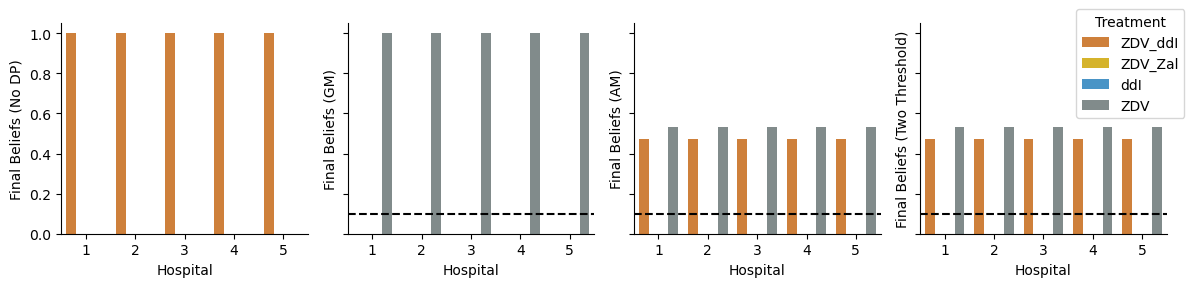

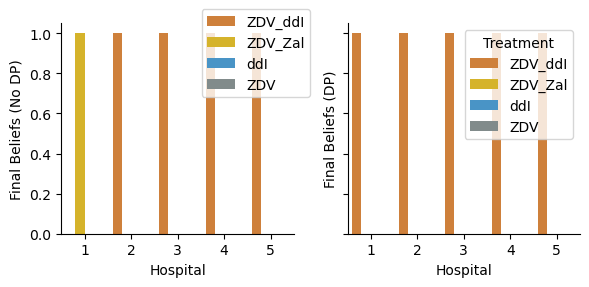

In [ ]:
def to_beliefs(x):
    # add one 0 in the start
    x = np.concatenate([np.zeros(1), x])
    x = softmax(x)
    return x / x.sum()

def distributed_survival_analysis_multi(df, num_hospitals, epsilon, alpha, beta, control, treatments, G, time_col, event_col, alternative, rho=0.01, intermittent=False, num_iterations=1000, num_runs=10, suffix=''):

    threshold = 1 / (1 + np.exp(rho))

    log_belief_ratio_private_distributed_treatments = []
    log_belief_ratio_distributed_treatments = []

    T_min = np.inf
    T_max = -np.inf

    A, n = build_network(G)

    for name, val in treatments:
        df_trt = df.query(f'trt == {val} | trt == {control[1]}')
        if intermittent:
            log_belief_ratio_private_distributed, log_belief_ratio_distributed, _, _, _ = distributed_survival_analysis(df=df_trt, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, beta=beta, covariate=name, G=G, time_col=time_col, event_col=event_col, alternative=alternative, rho=rho, plot=False, intermittent=intermittent, num_iterations=num_iterations, num_runs=num_runs)
            T_min = min(T_min, log_belief_ratio_private_distributed.shape[-1])
            T_max = max(T_max, log_belief_ratio_private_distributed.shape[-1])
        else:
            log_belief_ratio_private_distributed, log_belief_ratio_distributed, _, _, _, _, _, _, _ = distributed_survival_analysis(df=df_trt, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, beta=beta, covariate=name, G=G, time_col=time_col, event_col=event_col, alternative=alternative, rho=rho, plot=False, intermittent=intermittent, num_iterations=num_iterations, num_runs=num_runs)
            T_min = num_iterations
            T_max = num_iterations

        log_belief_ratio_private_distributed_treatments.append(log_belief_ratio_private_distributed)
        log_belief_ratio_distributed_treatments.append(log_belief_ratio_distributed)

    if intermittent:
        temp_array = []
        temp_private_array = []
        
        for j in range(len(treatments)):
            temp = np.zeros((num_hospitals, T_max))
            temp_private = np.zeros((num_hospitals, T_max))
            log_belief_ratio_distributed = log_belief_ratio_distributed_treatments[j]
            log_belief_ratio_private_distributed = log_belief_ratio_private_distributed_treatments[j]

            for t in range(T_max):
                if t <= log_belief_ratio_distributed.shape[-1] - 1:
                    temp[ :, t] = log_belief_ratio_private_distributed[ :, t]
                    temp_private[ :, t] = log_belief_ratio_distributed[:, t]
                else:
                    temp[:, t] = A @ temp[:, t-1]
                    temp_private[:, t] = A @ temp_private[:, t-1]

            temp_array.append(temp)
            temp_private_array.append(temp_private)

        log_belief_ratio_private_distributed_treatments = np.array(temp_private_array)
        log_belief_ratio_distributed_treatments = np.array(temp_array)

    else:
        log_belief_ratio_private_distributed_treatments = np.array(log_belief_ratio_private_distributed_treatments)
        log_belief_ratio_distributed_treatments = np.array(log_belief_ratio_distributed_treatments)

    records = []

    for i in range(num_hospitals):
        beliefs = to_beliefs(log_belief_ratio_distributed_treatments[:, i, -1])

        if intermittent:
            beliefs_private = to_beliefs(log_belief_ratio_private_distributed_treatments[:, i, -1])
        else:
            beliefs_private_gm = to_beliefs(log_belief_ratio_private_distributed_treatments[:, i, :, -1].mean(-1))

            beliefs_private_am = np.zeros_like(beliefs_private_gm)
            beliefs_private_count = np.zeros_like(beliefs_private_gm)

            for k in range(num_runs):
                beliefs_tmp = to_beliefs(log_belief_ratio_private_distributed_treatments[:, i, k, -1])
                beliefs_private_am += beliefs_tmp

                beliefs_private_count += (beliefs_tmp > threshold).astype(np.float64)

            beliefs_private_am /= num_runs
            beliefs_private_count /= num_runs

        for j, (name, val) in enumerate(treatments + [control]):
            record = {
                'Hospital' : i + 1,
                'Treatment' : name,
                'Final Beliefs (No DP)' : beliefs[j],
            }

            if intermittent:
                record['Final Beliefs (DP)'] = beliefs_private[j]
            else:
                record['Final Beliefs (GM)'] = beliefs_private_gm[j]
                record['Final Beliefs (AM)'] = beliefs_private_am[j]
                record['Final Beliefs (Two Threshold)'] = beliefs_private_count[j]

            records.append(record)

    records = pd.DataFrame(records)


    if intermittent:
        fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
        sns.barplot(x='Hospital', y='Final Beliefs (No DP)', hue='Treatment', data=records, ax=ax[0])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (DP)', hue='Treatment', data=records, ax=ax[1])
        sns.despine()

        ax[0].legend().remove()

        # move legend
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        
        fig.tight_layout()
        fig.savefig(f'figures/final_beliefs_multi_ol{suffix}.pdf', bbox_inches='tight')
    else:
        fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

        sns.barplot(x='Hospital', y='Final Beliefs (No DP)', hue='Treatment', data=records, ax=ax[0])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (GM)', hue='Treatment', data=records, ax=ax[1])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (AM)', hue='Treatment', data=records, ax=ax[2])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (Two Threshold)', hue='Treatment', data=records, ax=ax[3])
        sns.despine()

        ax[1].axhline(threshold, color='black', linestyle='--', label='Threshold')
        ax[2].axhline(threshold, color='black', linestyle='--', label='Threshold')
        ax[3].axhline(threshold, color='black', linestyle='--', label='Threshold')

        # remove legend
        ax[0].legend().remove()
        ax[1].legend().remove()
        ax[2].legend().remove()

        sns.move_legend(ax[3], "upper right", bbox_to_anchor=(1.1, 1.1))

        fig.tight_layout()

        fig.savefig(f'figures/final_beliefs_multi{suffix}.pdf', bbox_inches='tight')

thres = 0.1
rho = np.log(1/thres - 1)

distributed_survival_analysis_multi(df_atsg_multi, num_hospitals=5, epsilon=0.1, alpha=0.1, beta=0.9, control=('ZDV', 0), treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)], G=nx.erdos_renyi_graph(5, p=0.7), time_col='time', event_col='label', alternative=np.ones(1), rho=rho, num_iterations=100, num_runs=500)
distributed_survival_analysis_multi(df_atsg_multi, num_hospitals=5, epsilon=0.1, alpha=0.2, beta=0.8, control=('ZDV', 0), treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)], G=nx.erdos_renyi_graph(5, p=0.7), time_col='time', event_col='label', alternative=np.ones(1), rho=rho, num_iterations=100, num_runs=10, intermittent=True)

### Runtime plots

In [ ]:
def plot_runtime(df, suffix='', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT'):

    num_hospitals_range = 3 * 2**np.arange(0, 6)

    df_4096 = df.sample(n=4096, replace=True)
    df_8192 = df.sample(n=8192, replace=True)

    df_10xdataset = pd.concat([df_4096] * 10)

    records = []

    for num_hospitals in num_hospitals_range:
        print(f'n = {num_hospitals}')
        _, _, runtime_likelihoods_4096, runtime_communication_4096, _, _, _, _, _ = distributed_survival_analysis(df_4096, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=np.ones(1), plot=False)
        _, _, runtime_likelihoods_8192, runtime_communication_8192, _, _, _, _, _ = distributed_survival_analysis(df_8192, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=np.ones(1), plot=False)
        _, _, runtime_likelihoods_10xdataset, runtime_communication_10xdataset, _, _, _, _, _ = distributed_survival_analysis(df_10xdataset, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=np.ones(1), plot=False)

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_4096,
            'Initialization Runtime (s)' : runtime_likelihoods_4096,
            'Total Runtime (s)' : runtime_communication_4096 + runtime_likelihoods_4096,
            't.p.' : '4096'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_8192,
            'Initialization Runtime (s)' : runtime_likelihoods_8192,
            'Total Runtime (s)' : runtime_communication_8192 + runtime_likelihoods_8192,
            't.p.' : '8192'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_10xdataset,
            'Initialization Runtime (s)' : runtime_likelihoods_10xdataset,
            'Total Runtime (s)' : runtime_communication_10xdataset + runtime_likelihoods_10xdataset,
            't.p.' : '10x dataset'
        })
        
    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    sns.barplot(x='Number of Data Providers', y='Communication Runtime (s)', data=records, hue='t.p.', ax=ax[1])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Initialization Runtime (s)', data=records, hue='t.p.', ax=ax[0])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Total Runtime (s)', data=records, hue='t.p.', ax=ax[2])
    sns.despine()

    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    # remove legend
    ax[0].legend().remove()
    ax[1].legend().remove()

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')

    fig.supxlabel('Number of Data Providers')

    fig.tight_layout()

    fig.savefig(f'figures/runtime{suffix}.pdf', bbox_inches='tight')


plot_runtime(df_tmb, suffix='', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT')
plot_runtime(df_atsg, suffix='_atsg', covariate='ddI', time_col='time', event_col='label')


### Error vs. privacy budget plots

In [ ]:
def plot_errors(df, suffix='', covariate='ddI', time_col='time', event_col='label', eps_min=0.1, eps_max=1.5, eps_step=0.1):

    num_hospitals_range = [3, 6, 12, 24, 48, 96]

    eps_range = np.arange(eps_min, eps_max + eps_step, eps_step)
    records = []

    min_tvd_gm, max_tvd_gm = np.inf, -np.inf
    min_tvd_am, max_tvd_am = np.inf, -np.inf

    for num_hospitals in num_hospitals_range:
        for eps in eps_range:    
            _, _, _, _, tvd_gm, tvd_am, tvd_count, type_1_gm, type_2_am = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.3, beta=0.7, covariate=covariate, node_layout='dot', suffix='_tmb_star', time_col=time_col, event_col=event_col, alternative=np.ones(1), plot=False, rho=0.1)
            _, _, _, _, tvd_ol = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.3, beta=0.7, covariate=covariate, node_layout='dot', suffix='_tmb_star_ol', time_col=time_col, event_col=event_col, alternative=np.ones(1), plot=False, rho=0.1, intermittent=True, intermittent_period=10)

            jitter = np.random.uniform(-0.05, 0.05)

            records.append({
                'Number of Data Providers ($n$)' : num_hospitals,
                'Privacy Budget ($\epsilon$)' : eps,
                'Total Variation Distance (GM)' : max(0, min(1, tvd_gm + jitter)),
                'Total Variation Distance (AM)' : max(0, min(1, tvd_am + jitter)),
                'Total Variation Distance (Count)' : max(0, min(1, tvd_count + jitter)),
                'Total Variation Distance (OL)' : max(0, min(1, tvd_ol + jitter)),
                'Type I Error (GM)' : type_1_gm + jitter,
                'Type II Error (AM)' : type_2_am + jitter
            })

            min_tvd_gm = min(min_tvd_gm, tvd_gm)
            max_tvd_gm = max(max_tvd_gm, tvd_gm)

            min_tvd_am = min(min_tvd_am, tvd_am)
            max_tvd_am = max(max_tvd_am, tvd_am)

    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 4, figsize=(12, 3))

    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (GM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[0], markers=True, legend=False, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (AM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[1], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (Count)', data=records, hue='Number of Data Providers ($n$)', ax=ax[2], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (OL)', data=records, hue='Number of Data Providers ($n$)', ax=ax[3], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()

    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='$n$')

    fig.tight_layout()

    fig.savefig(f'figures/tvd_errors{suffix}.pdf', bbox_inches='tight')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')
    ax[3].set_xlabel('')

    ax[0].set_ylabel('GM')
    ax[1].set_ylabel('AM')
    ax[2].set_ylabel('Two Threshold')
    ax[3].set_ylabel('OL')

    fig.supxlabel('Privacy Budget ($\epsilon$)')
    fig.supylabel('Total Variation Distance')

    fig.tight_layout()

    fig.savefig(f'figures/tvd_errors{suffix}.pdf', bbox_inches='tight')
  
plot_errors(df_atsg)
plot_errors(df_tmb, suffix='_tmb', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', eps_min=1, eps_max=10, eps_step=1)

## Critical Thresholds for Data Sharing

The following code reproduces the figures used in the example presented in the paper. 

### Randomized Response Mechanism

In [ ]:
import scipy.stats

def binary_signal_statistical_power_individual(p, alpha):
    if 1 - p < alpha:
        return p + (1 - p) * (alpha - 1 + p) / p
    elif 1 - p == alpha:
        return p
    else:
        return p * alpha / (1 - p)

def binary_signals_statistical_power_rr(n, p, epsilon, alpha=0.05):

    p_eps = 1 / (1 + np.exp(epsilon))

    q = p * p_eps + (1 - p) * (1 - p_eps)

    threshold = scipy.stats.binom.isf(alpha, n, q)
    power =  scipy.stats.binom.sf(threshold, n, 1 - q)
    return power

def decision_threshold_rr(n, p, alpha):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon) for epsilon in epsilons])

    beta_ind = binary_signal_statistical_power_individual(p, alpha)

    # find first epsilon where power is greater than p

    threshold = np.argmin(np.abs(beta_ind - powers))

    return epsilons[threshold]

def plot_decision_thresholds_rr():

    n_range = [25, 50, 75, 100]
    p_range = [0.6, 0.7, 0.8, 0.9]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_rr(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('Correct Signal Prob. ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Critical Budget $\epsilon^*_{RR}$')

    fig.savefig('figures/decision_thresholds.pdf', bbox_inches='tight')

def binary_signals_curve_n_rr(p, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n.pdf', bbox_inches='tight')


def binary_signals_curve_p_rr(n, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.6, 0.7, 0.8, 0.9]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

        # # find intersection point between p and powers
        # intersection = np.argmin(np.abs(p - powers))

        # ax.plot([epsilons[intersection]], [p], 'o', color=palette[i])

    sns.despine()


    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p.pdf', bbox_inches='tight')

binary_signals_curve_n_rr(0.7)
binary_signals_curve_p_rr(100)

plot_decision_thresholds_rr()


### Laplace Mechanism

In [ ]:
def binary_signals_statistical_power_laplace(n, p, epsilon, alpha=0.05, num_iters=5000):

    Delta = np.abs(np.log((1 - p) / p))

    # calculate LRT under H0
    LRTs_H0 = np.zeros(num_iters)
    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, 1 - p)

        LRTs_H0[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    threshold = np.percentile(LRTs_H0, 100 * (1 - alpha))

    LRTs_HA = np.zeros(num_iters)

    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, p)

        LRTs_HA[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    power = (LRTs_HA > threshold).mean()
    return power

def decision_threshold_laplace(n, p, alpha=0.05):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon) for epsilon in epsilons])

    threshold = np.argmin(np.abs(binary_signal_statistical_power_individual(p, alpha) - powers))

    return epsilons[threshold]

def plot_decision_thresholds_laplace():
    
    n_range = [25, 50, 75, 100]
    p_range = [0.6, 0.7, 0.8, 0.9]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_laplace(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('Correct Signal Prob. ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Critical Budget $\epsilon^*_{Laplace}$')

    fig.savefig('figures/decision_thresholds_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_n_laplace(p, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_p_laplace(n, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.6, 0.7, 0.8, 0.9]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

    sns.despine()

    ax.legend()


    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p_laplace.pdf', bbox_inches='tight')

binary_signals_curve_n_laplace(0.7)
binary_signals_curve_p_laplace(100)

plot_decision_thresholds_laplace()
